# Predicting house prices

Here our target is to predict the houses of an unknown data set

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(20,7)})


import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

## Preprocessing data 

We want to start by cleaning up the data for training

In [31]:
# Load all data
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

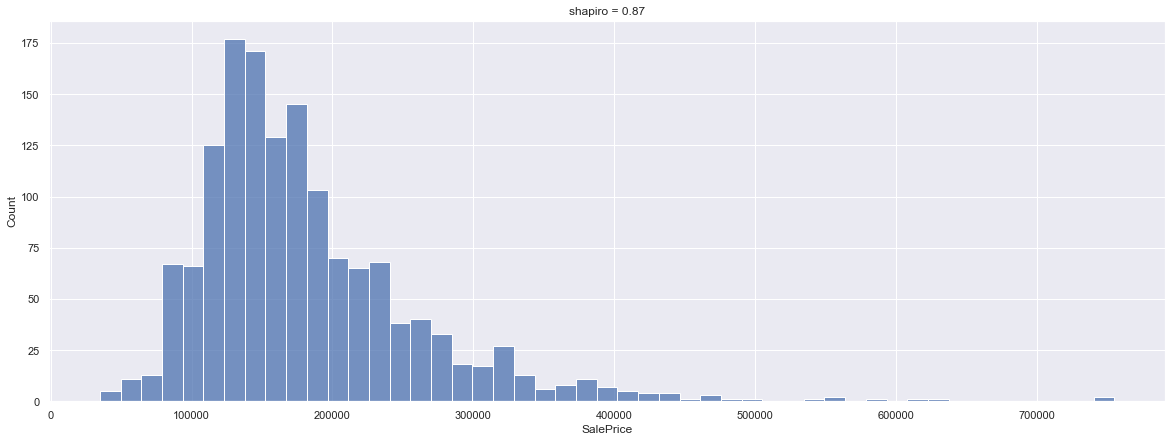

In [67]:
# SalePrice is our target feature that we want to predict
# The distribution is slightly skewed inidcating a log normal distribution

shap1 = np.round(stats.shapiro(train['SalePrice'])[0],3)

sns.histplot(train['SalePrice'], color='b')
plt.title('shapiro = {}'.format(shap1))

plt.show()

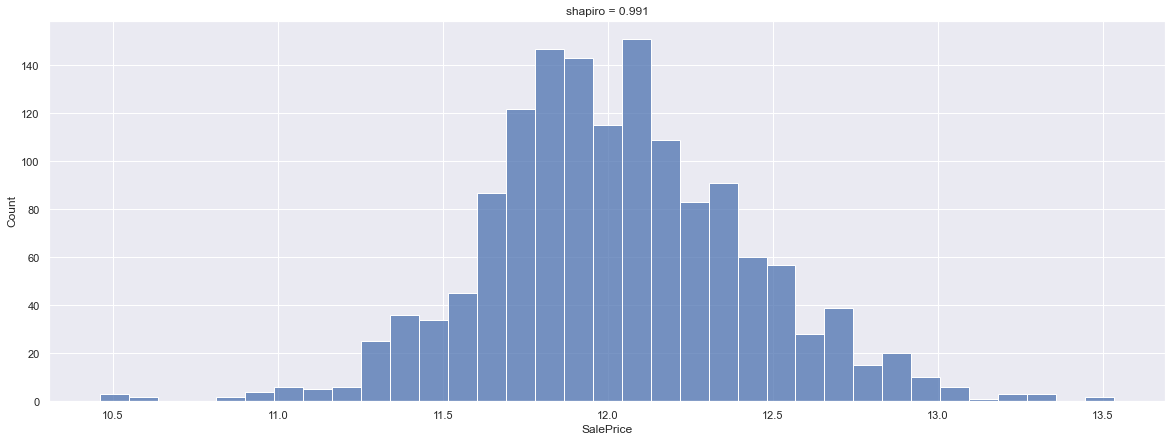

In [68]:
shap2 = np.round(stats.shapiro(np.log(train['SalePrice']))[0],3)

sns.histplot(np.log(train['SalePrice']), color='b')
plt.title('shapiro = {}'.format(shap2))

plt.show()

<AxesSubplot:>

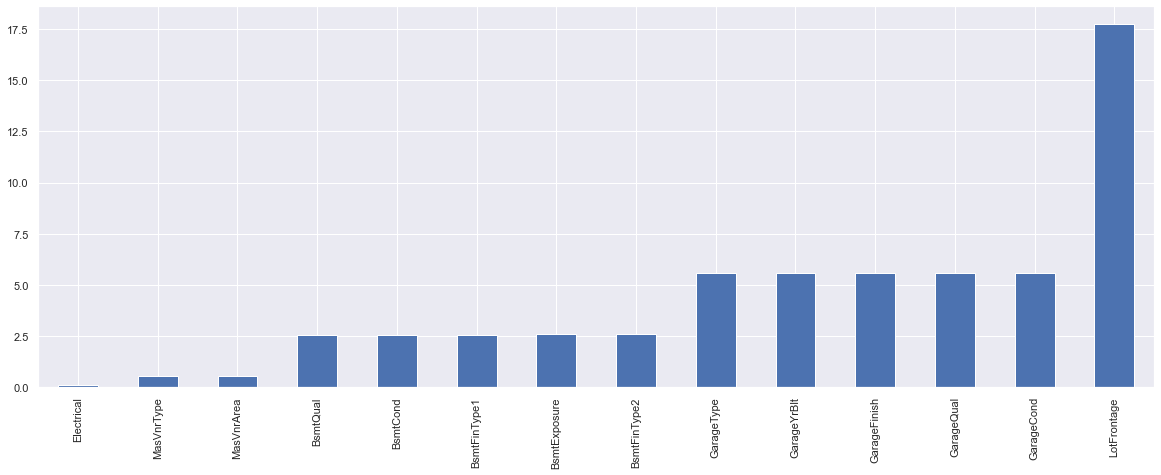

In [69]:
# lets look at all missing data as a percentage
missing = train.isnull().sum()
missing = missing[missing>0]
missing = 100 * missing/len(train)
missing.sort_values(inplace=True)

missing.plot.bar()

In [90]:
# Drop all variables that are missing over 40% of the data 
train = train.drop(labels = missing[missing>30].keys(), axis=1)
test = test.drop(labels = missing[missing>30].keys(), axis=1)

# For the rest of the nans we will just replace them all with zeros 
train = train.fillna(0)
test = test.fillna(0)

In [88]:
# Turn categorial labels into strings 
catCols = [col for col in train.columns if train[col].dtype == 'O']
le = LabelEncoder()

def label_encode(df, cols):
    
    df = df.copy()
    for col in cols:
        df[col] = le.fit_transform(df[col])
        
    return df

# Encode all data
train = label_encode(train, catCols)
test = label_encode(train, catCols)

0

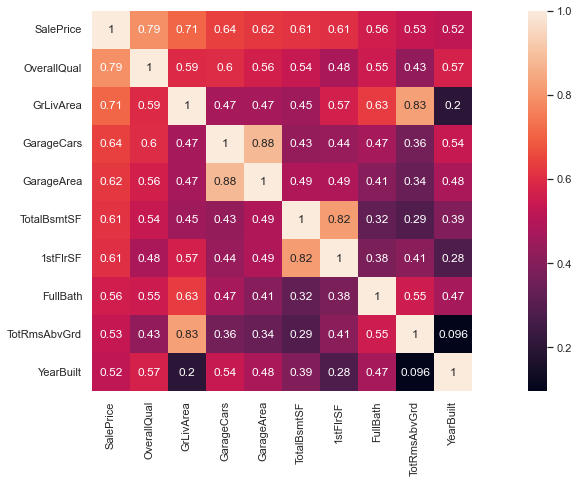

In [91]:
# Let's now look at the correlations between the other independent variables and the target
corrmat = train.corr()

# Sort columns 10 most highly correlated variables
cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)

# Create heat maps of correlations of variables with each other 
sns.heatmap(cm, cbar=True, square=True, annot=True, yticklabels=cols.values, xticklabels=cols.values)

plt.show()


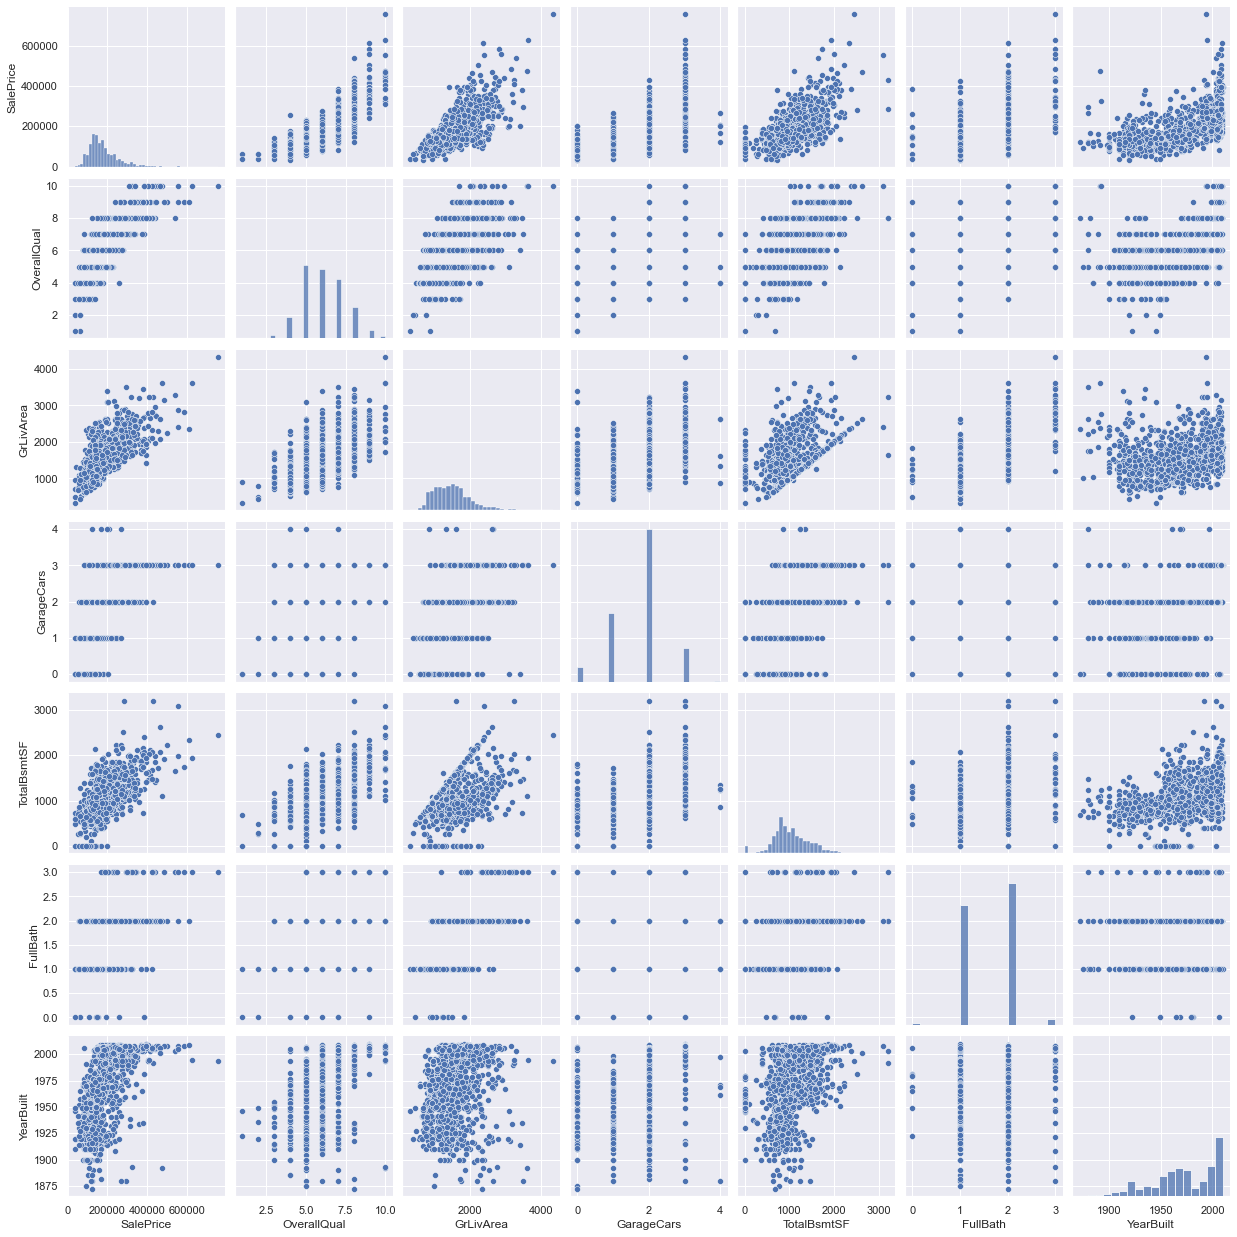

In [247]:
# Clearly GarageCars and GarageArea are highly correlated and so to is TotalBsmtSF
# Is highly correlated with 1stFlrSF so we will not include these

cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], height = 2.5)

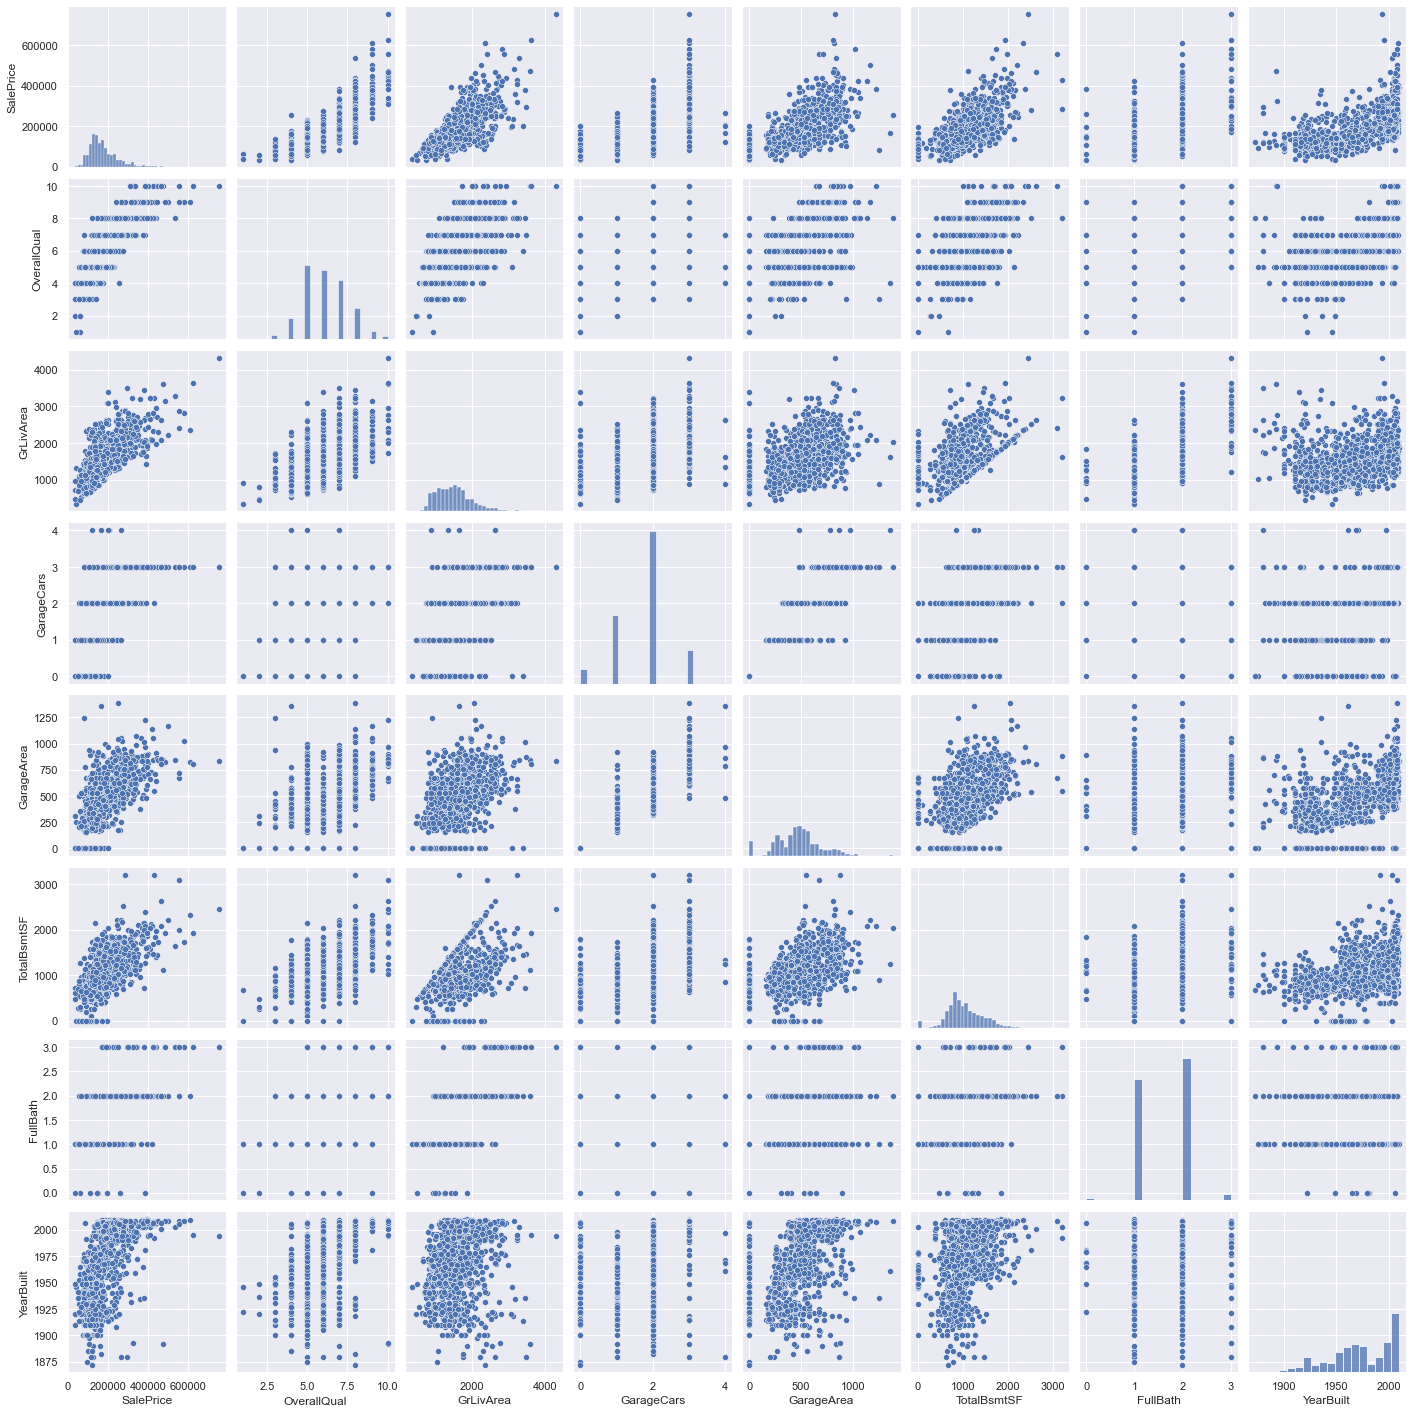

In [237]:
# Drop outlines in the Sales price
train = train[train.GrLivArea <4400]
train = train[train.TotalBsmtSF <4400]

sns.pairplot(train[cols], height=2.5)

In [238]:
# Let's now run Ordinary least squares on this problem but first replace sales price with it's log
# Only include columns used above
X_cols = cols.copy()

X_cols.remove('SalePrice')
train_X = train[X_cols]
train_y = np.log(train['SalePrice'])

# Get test data too
test_X = test[X_cols]

In [239]:
# Check for nulls
test_X.isnull().sum()

OverallQual    0
GrLivArea      0
GarageCars     1
GarageArea     1
TotalBsmtSF    1
FullBath       0
YearBuilt      0
dtype: int64

In [240]:
# So it doesn't look like there are many with nans, let us just drop these columns
train_X = train_X.fillna(0)
test_X = test_X.fillna(0)

In [241]:
# Create a test_train_split
train_X_1, test_X_1, train_y_1, test_y_1 = train_test_split(train_X, train_y, test_size=0.5)

In [309]:
# train on ordinary least squares
LR_model = LinearRegression()
LR_model.fit(train_X_1, train_y_1)

LR_scores = cross_val_score(LR_model, test_X_1, test_y_1)
LR_mean_score = LR_scores.mean()
LR_std_score = LR_scores.std()

# Print scores
print(f"Mean RMSE = {LR_mean_score:.2f}")
print(f"StDev RMSE = {LR_std_score:.2f}")

Mean RMSE = 0.85
StDev RMSE = 0.03


In [310]:
# Lets see how good our model is 
predictedPrice_log = pd.DataFrame(LR_model.predict(train_X), columns=['Predicted Price'])
actualPrice_log = pd.DataFrame(train_y.values, columns=['Actual Price'])  

# Convert back to actual price
actualPrice = np.exp(actualPrice_log)
predictedPrice = np.exp(predictedPrice_log)

df = pd.concat([actualPrice, predictedPrice], axis=1)

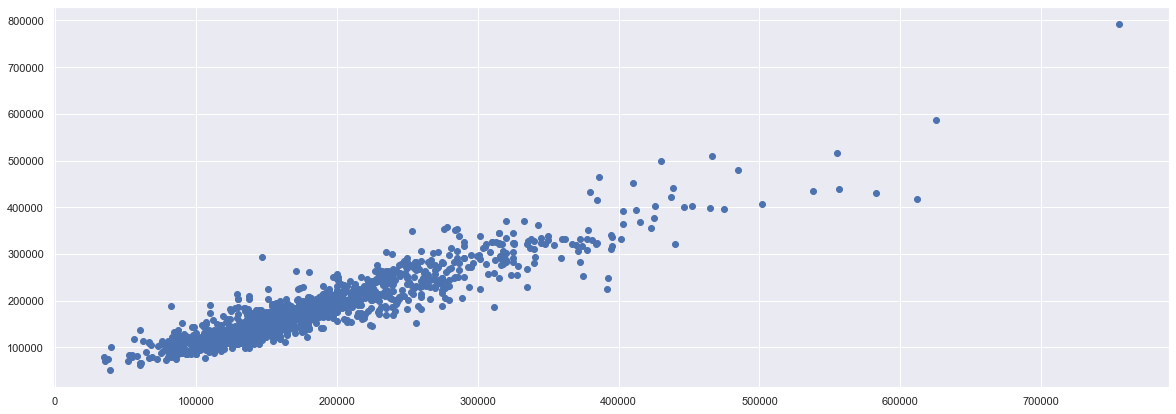

In [311]:
plt.scatter(actualPrice, predictedPrice)

plt.show()

In [312]:
# Now get predicted values
test_y = LR_model.predict(test_X)

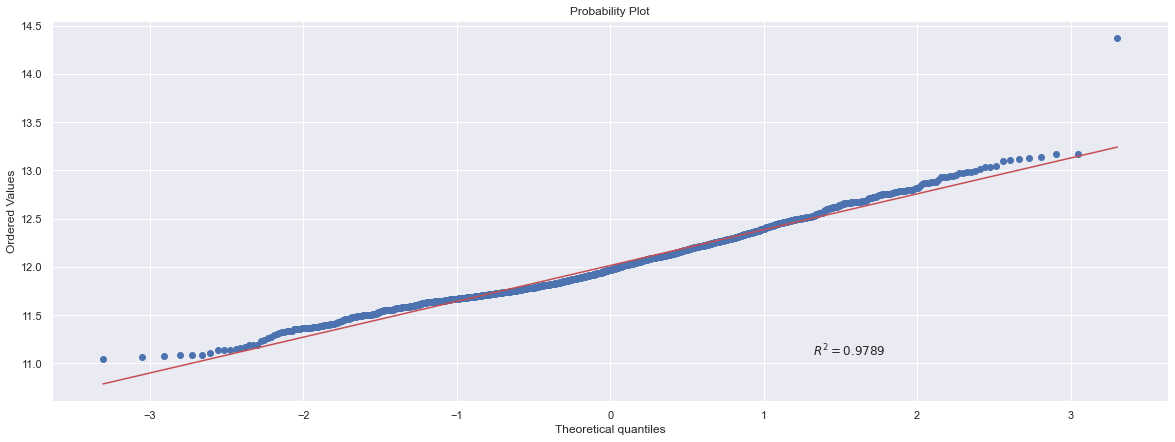

In [313]:
# Let's take a look this data
stats.probplot(test_y, plot=plt, rvalue=True)

plt.show()

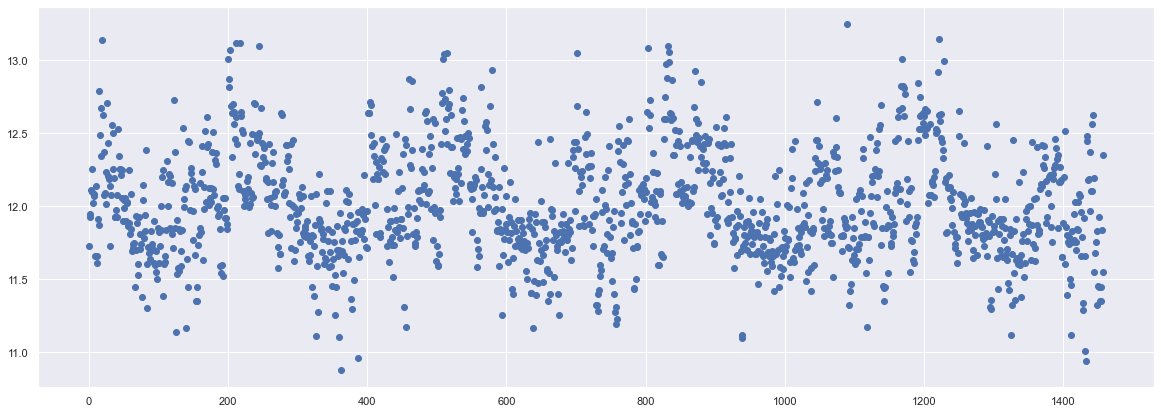

In [302]:
# So it looks like there is one whopping outlier, which will ultimately bring our score down
plt.scatter(np.arange(len(test_y)), test_y)

In [303]:
# Create data frame with prediction results
test['SalePrice'] = np.exp(test_y)
ixmax = test['SalePrice'].idxmax()

# Get outlier
outlier = test.iloc[ixmax]

In [304]:
# Find most similar data point
diff = test[X_cols].drop(labels=ixmax, axis=0) - outlier[X_cols]
norm_df = diff.apply(np.linalg.norm, axis=1)
most_similar = test.loc[norm_df.idxmin()]

most_similar[cols] - outlier[cols]

SalePrice     -56811.170153
OverallQual              -1
GrLivArea             -2399
GarageCars              0.0
TotalBsmtSF         -2249.0
FullBath                  0
YearBuilt                -5
dtype: object

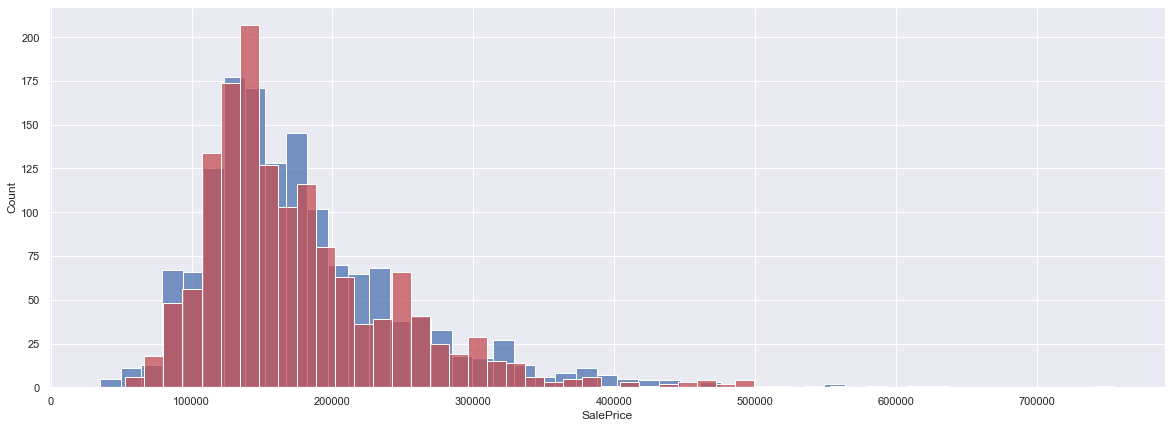

In [305]:
fig, ax = plt.subplots()

sns.histplot(np.exp(train_y), ax=ax, color='b')
sns.histplot(np.exp(test_y), ax=ax, color='r')

plt.show()

In [307]:
# Create data submission 
test['SalePrice'] = np.exp(test_y)
submission = test[['Id', 'SalePrice']]
submission.to_csv('./data/submission.csv', index=None)